# Bird Classifier using Transfer Learning from MobileNetv2

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import Sequential
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.callbacks import ModelCheckpoint

import warnings
warnings.filterwarnings('ignore')

## Set Hyperparameters

In [2]:
FILEPATH = '../Kaggle500Dataset/' # filepath for data
BATCH_SIZE = 128 # keras training batch size
IMAGE_SIZE = (224, 224) # size of images in dataset (keras will resize)

BIRD_SPECIES = 517


ROUND_1_TRAINABLE_LAYERS = 0 # layers at end of the mobile_net base model to have trainable parameters
ROUND_1_EPOCHS = 20

ROUND_2_TRAINABLE_LAYERS = 38
ROUND_2_LEARNING_SCALER = 0.2
ROUND_2_EPOCHS = 20

ROUND_3_TRAINABLE_LAYERS = 74
ROUND_3_LEARNING_SCALER = 0.2
ROUND_3_EPOCHS = 20

LEARNING_RATE = 0.001

MODEL_CHECKPOINT_FILEPATH = './mobilenetv2/Bird-Classifier-Model-Checkpoint.ckpt'

SEED = 6278 # random seed for repeatability of notebook

## Load Datasets with *image_dataset_from_directory*

In [3]:
# Training Dataset
train = image_dataset_from_directory(directory = FILEPATH + 'train/',
                                     shuffle = True,
                                     labels='inferred',
                                     label_mode='categorical',
                                     batch_size = BATCH_SIZE,
                                     image_size = IMAGE_SIZE,
                                     seed = SEED)

# Validation Dataset
valid = image_dataset_from_directory(directory = FILEPATH + 'valid/',
                                     shuffle = True,
                                     labels='inferred',
                                     label_mode='categorical',
                                     batch_size = BATCH_SIZE,
                                     image_size = IMAGE_SIZE,
                                     seed = SEED)

# Test Dataset
test = image_dataset_from_directory(directory = FILEPATH + 'test/',
                                     shuffle = True,
                                     labels='inferred',
                                     label_mode='categorical',
                                     batch_size = BATCH_SIZE,
                                     image_size = IMAGE_SIZE,
                                     seed = SEED)

Found 82966 files belonging to 517 classes.
Found 2585 files belonging to 517 classes.
Found 2585 files belonging to 517 classes.


## Visualize Data Samples

2023-05-26 22:30:02.678100: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


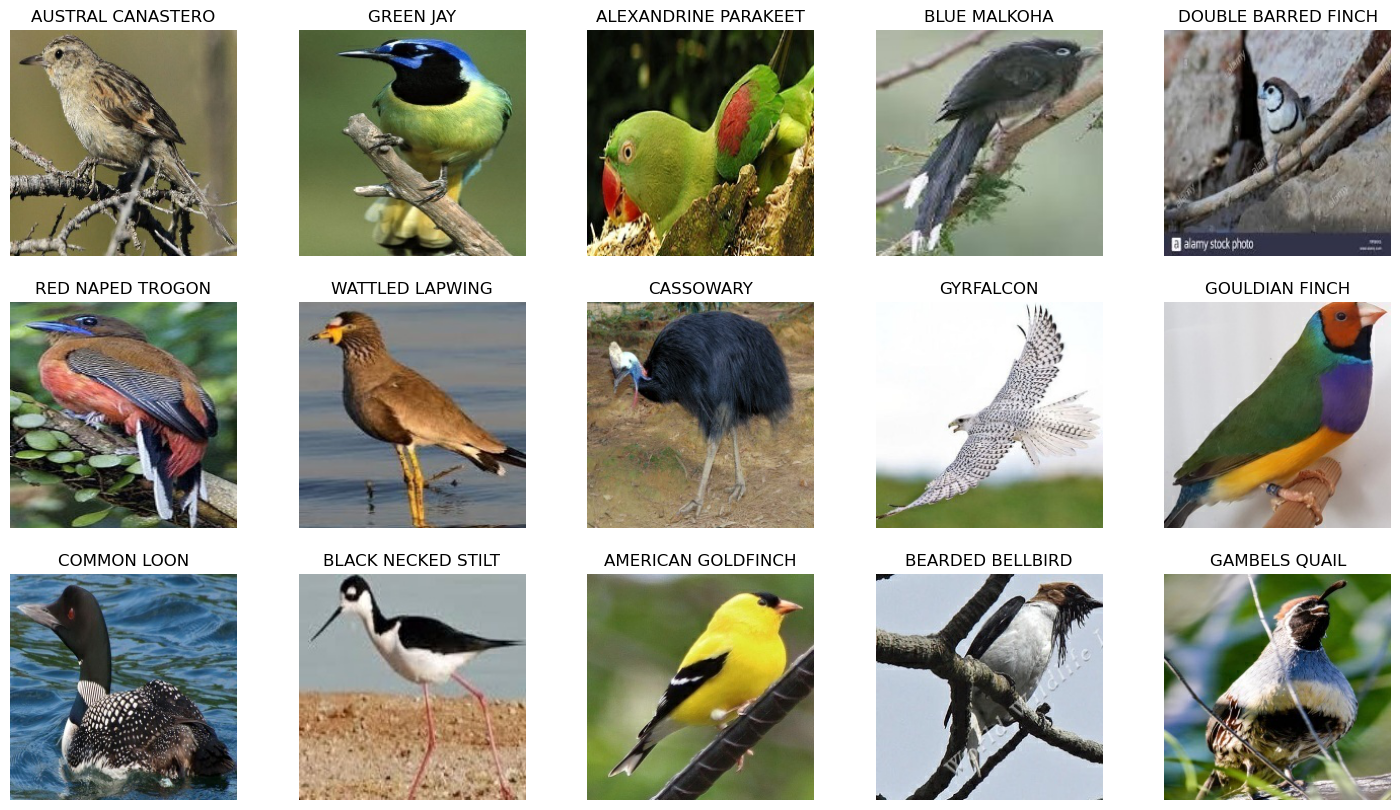

In [4]:
class_names = train.class_names

plt.figure(figsize=(18, 10))

for images, labels in train.take(1):
    for i in range(15):
        ax = plt.subplot(3, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[np.argmax(labels[i])])
        plt.axis("off")

# Data Augmentation

In [5]:
def data_augmentor(h_flip=True, v_flip=False, rotate=True, zoom=False):
    
    augmentor = Sequential() # Create returned Sequential class.
    augmentor.add(layers.Rescaling(1./255)) # Rescale image values from 0 - 255 to 0 - 1.

    # Based on function arguments: perform random flipping
    if h_flip and v_flip:
        augmentor.add(layers.RandomFlip('horizontal_and_vertical'))
    elif h_flip:
        augmentor.add(layers.RandomFlip('horizontal'))
    elif v_flip:
        augmentor.add(layers.RandomFlip('vertical'))

    # Based on function arguments: perform random rotation    
    if rotate:
        augmentor.add(layers.RandomRotation(0.2))
        
    if zoom:
        augmentor.add(layers.RandomZoom(0.2))
    
    return augmentor

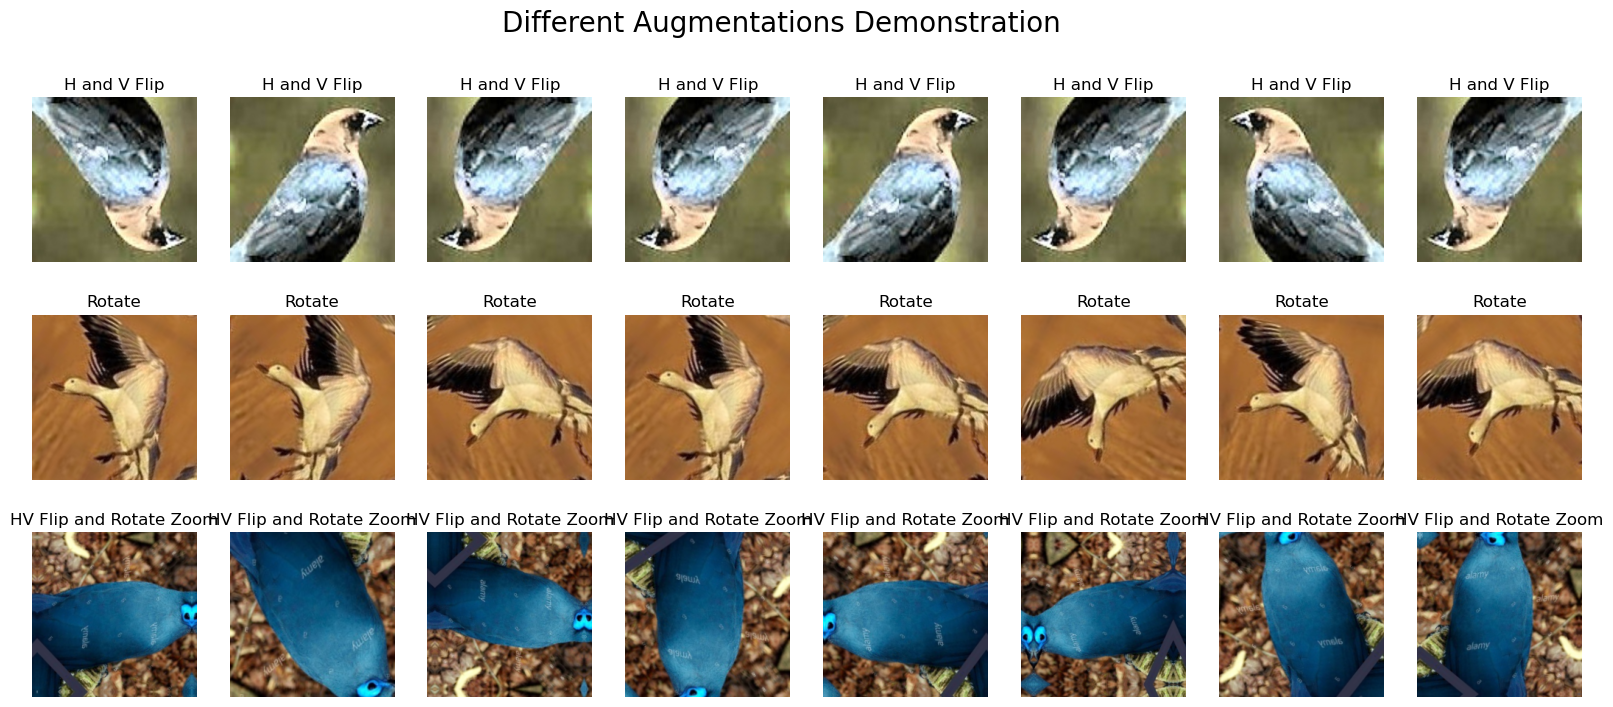

In [6]:
augmentor1 = data_augmentor(h_flip = True, v_flip = True, rotate=False)
augmentor2 = data_augmentor(h_flip = False, v_flip = False, rotate=True)
augmentor3 = data_augmentor(h_flip = True, v_flip = False, rotate=True)
augmentor4 = data_augmentor(h_flip = True, v_flip = True, rotate=True, zoom=True)

augs = [augmentor1, augmentor2, augmentor4]

details = ['H and V Flip',
           'Rotate',
           'HV Flip and Rotate Zoom']

plt.figure(figsize=(20, 8))
for images, labels in train.take(1):
    for i, aug in enumerate(augs):
        img = images[i]
        for j in range(8):
            ax = plt.subplot(3, 8, (i*8 + j + 1))
            img_augmented = aug(tf.expand_dims(img, 0))
            plt.imshow(img_augmented[0])
            plt.axis('off')
            ax.set_title(details[i])

plt.suptitle('Different Augmentations Demonstration', fontsize=20);

# Import MobileNetV2 Base Model

In [7]:
IMAGE_SHAPE = IMAGE_SIZE + (3,)

mobile_base = MobileNetV2(input_shape = IMAGE_SHAPE,
                          include_top = False,
                          weights = 'imagenet')

mn_layers = len(mobile_base.layers)

In [8]:
mobile_base.trainable = True

print('Setting the last {} layers in the Mobile Net Base Model to trainable!\n'.format(ROUND_1_TRAINABLE_LAYERS))

for mn_layer in mobile_base.layers[:-ROUND_1_TRAINABLE_LAYERS]:
    mn_layer.trainable = False
    
trainableParams = np.sum([np.prod(v.get_shape()) for v in mobile_base.trainable_weights])
nonTrainableParams = np.sum([np.prod(v.get_shape()) for v in mobile_base.non_trainable_weights])
totalParams = trainableParams + nonTrainableParams

print('The number of trainable parameters in the Mobile Net V2 Base Model is {}.'.format(trainableParams))
print('The number of non-trainable parameters in the Mobile Net V2 Base Model is {}.'.format(nonTrainableParams))
print('The total number of parameters is {}.'.format(totalParams))

Setting the last 0 layers in the Mobile Net Base Model to trainable!

The number of trainable parameters in the Mobile Net V2 Base Model is 2223872.
The number of non-trainable parameters in the Mobile Net V2 Base Model is 34112.
The total number of parameters is 2257984.


# Build Model
## Augmentor &rarr; Mobile Net V2 Base &rarr; 3 Dense Layers resulting in Softmax Output

In [9]:
# start model with input shape equal to image shape
inputs = tf.keras.Input(shape = IMAGE_SHAPE)
# apply h-flip and rotation data augmentation
x = augmentor4(inputs)
# apply through mobile net v2 base
x = mobile_base(x)
# x = mobile_base(inputs)
# global average pool to collapse to 1D
x = layers.GlobalAveragePooling2D()(x) 
# normalize layer
x = layers.BatchNormalization()(x)
# apply relu activation
x = layers.ReLU()(x)
# include dropout with probability of 0.2 to avoid overfitting
x = layers.Dropout(0.25)(x)
# densely connected layer with 2000
x = layers.Dense(1500)(x) 
# normalize layer
x = layers.BatchNormalization()(x)
# apply relu activation
x = layers.ReLU()(x)
# include dropout with probability of 0.2 to avoid overfitting
x = layers.Dropout(0.25)(x)
# densely connected output layer with same number of output classes
x = layers.Dense(1200)(x) 
# normalize layer
x = layers.BatchNormalization()(x)
# apply relu activation
x = layers.ReLU()(x)
# include dropout with probability of 0.2 to avoid overfitting
x = layers.Dropout(0.25)(x)
# densely connected output layer with same number of output classes
x = layers.Dense(900)(x) 
# normalize layer
x = layers.BatchNormalization()(x)
# apply relu activation
x = layers.ReLU()(x)
# include dropout with probability of 0.2 to avoid overfitting
x = layers.Dropout(0.25)(x)
# densely connected output layer with same number of output classes
outputs = layers.Dense(BIRD_SPECIES, activation='softmax')(x) 
        
model = tf.keras.Model(inputs, outputs)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential_3 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 batch_normalization (BatchN  (None, 1280)             5120      
 ormalization)                                                   
                                                             

# Train Model

In [10]:
optimizer_1 = tf.keras.optimizers.Adam(learning_rate = LEARNING_RATE)

loss = tf.keras.losses.CategoricalCrossentropy(from_logits=False)

model_checkpoint = ModelCheckpoint(MODEL_CHECKPOINT_FILEPATH,
                                   monitor='val_accuracy',
                                   save_best_only=True,
                                   save_weights_only=True,
                                   verbose=1,
                                   mode = 'max')

callbacks = [model_checkpoint]

model.compile(optimizer = optimizer_1,
              loss = loss,
              metrics=['accuracy'])

In [11]:

history = model.fit(train, 
                    validation_data=valid, 
                    epochs=ROUND_1_EPOCHS,
                    callbacks= callbacks)

Epoch 1/20
649/649 [==============================] - ETA: 0s - loss: 2.9239 - accuracy: 0.3634
Epoch 1: val_accuracy improved from -inf to 0.00696, saving model to ./mobilenetv2/Bird-Classifier-Model-Checkpoint.ckpt
649/649 [==============================] - 1712s 3s/step - loss: 2.9239 - accuracy: 0.3634 - val_loss: 17.4957 - val_accuracy: 0.0070
Epoch 2/20
649/649 [==============================] - ETA: 0s - loss: 1.3116 - accuracy: 0.6586
Epoch 2: val_accuracy improved from 0.00696 to 0.02476, saving model to ./mobilenetv2/Bird-Classifier-Model-Checkpoint.ckpt
649/649 [==============================] - 1685s 3s/step - loss: 1.3116 - accuracy: 0.6586 - val_loss: 15.9531 - val_accuracy: 0.0248
Epoch 3/20
649/649 [==============================] - ETA: 0s - loss: 0.9835 - accuracy: 0.7368
Epoch 3: val_accuracy improved from 0.02476 to 0.19110, saving model to ./mobilenetv2/Bird-Classifier-Model-Checkpoint.ckpt
649/649 [==============================] - 1704s 3s/step - loss: 0.9835 - a

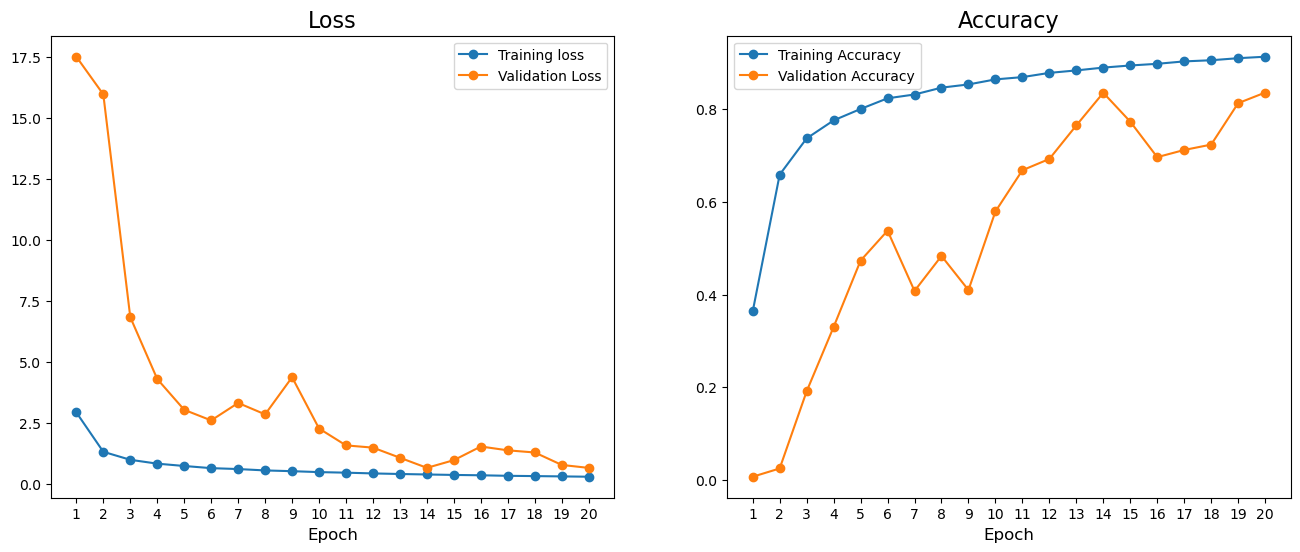

In [12]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,6))
title_fontsize = 16
axis_fontsize = 12

total_epochs = ROUND_1_EPOCHS

ax1.plot(range(1, total_epochs + 1), history.history['loss'], marker='o', label='Training loss')
ax1.plot(range(1, total_epochs + 1), history.history['val_loss'], marker='o', label='Validation Loss')
ax1.legend()
ax1.set_xticks(range(1, total_epochs + 1))
ax1.set_title('Loss', fontsize=title_fontsize)
ax1.set_xlabel('Epoch', fontsize=axis_fontsize)

ax2.plot(range(1, total_epochs + 1), history.history['accuracy'], marker='o', label='Training Accuracy')
ax2.plot(range(1, total_epochs + 1), history.history['val_accuracy'], marker='o', label='Validation Accuracy')
ax2.legend()
ax2.set_xticks(range(1, total_epochs + 1))
ax2.set_title('Accuracy', fontsize=title_fontsize)
ax2.set_xlabel('Epoch', fontsize=axis_fontsize);

In [13]:
test_loss, test_accuracy = model.evaluate(test)

print('\n\033[1m' + 'The model had an accuracy score of {}%!!'.format(round(100*test_accuracy,1)) + '\033[0m')

21/21 [==============================] - 11s 499ms/step - loss: 0.5471 - accuracy: 0.8511

The model had an accuracy score of 85.1%!!


In [14]:
import os
model_name = 'MobileNetV2'
subject = 'Birds-Species'
acc = test_accuracy * 100
save_path = ''

save_id = str(f'./Models/MobileNetV2/{model_name}-{subject}-{"%.2f" %round(acc, 2)}.h5')
model_save_loc = os.path.join(save_path, save_id)
model.save(model_save_loc)
print(f'model was saved as {model_save_loc}')

model was saved as ./Models/MobileNetV2/MobileNetV2-Birds-Species-85.11.h5


# Fine Tune

In [15]:
model.layers[2].trainable = True

print('Setting the last {} layers in the Mobile Net Base Model to trainable!'.format(ROUND_2_TRAINABLE_LAYERS))

for layer in model.layers[2].layers[:-ROUND_2_TRAINABLE_LAYERS]:
    layer.trainable = False

Setting the last 38 layers in the Mobile Net Base Model to trainable!


In [16]:
optimizer_2 = tf.keras.optimizers.Adam(learning_rate = LEARNING_RATE * ROUND_2_LEARNING_SCALER)

callbacks = [model_checkpoint, model.history]

model.compile(optimizer = optimizer_2,
              loss = loss,
              metrics=['accuracy'])

In [17]:
history = model.fit(train, 
                    validation_data=valid, 
                    epochs=ROUND_2_EPOCHS, 
                    callbacks = callbacks)

Epoch 1/20
649/649 [==============================] - ETA: 0s - loss: 0.2407 - accuracy: 0.9288
Epoch 1: val_accuracy improved from 0.83559 to 0.92766, saving model to ./mobilenetv2/Bird-Classifier-Model-Checkpoint.ckpt
649/649 [==============================] - 530s 815ms/step - loss: 0.2407 - accuracy: 0.9288 - val_loss: 0.2518 - val_accuracy: 0.9277
Epoch 2/20
649/649 [==============================] - ETA: 0s - loss: 0.1879 - accuracy: 0.9436
Epoch 2: val_accuracy improved from 0.92766 to 0.94894, saving model to ./mobilenetv2/Bird-Classifier-Model-Checkpoint.ckpt
649/649 [==============================] - 530s 816ms/step - loss: 0.1879 - accuracy: 0.9436 - val_loss: 0.1820 - val_accuracy: 0.9489
Epoch 3/20
649/649 [==============================] - ETA: 0s - loss: 0.1629 - accuracy: 0.9499
Epoch 3: val_accuracy improved from 0.94894 to 0.95319, saving model to ./mobilenetv2/Bird-Classifier-Model-Checkpoint.ckpt
649/649 [==============================] - 530s 816ms/step - loss: 0.1

In [18]:
history.history['loss']

[0.2407391518354416,
 0.18792536854743958,
 0.16293160617351532,
 0.15191051363945007,
 0.14310786128044128,
 0.1346416175365448,
 0.12802660465240479,
 0.12073441594839096,
 0.1152091771364212,
 0.11380136013031006,
 0.1089627593755722,
 0.10161001980304718,
 0.10349098592996597,
 0.10002928227186203,
 0.09588853269815445,
 0.09225186705589294,
 0.09083640575408936,
 0.08907070755958557,
 0.08399049192667007,
 0.08644039928913116]

Text(0.5, 0, 'Epoch')

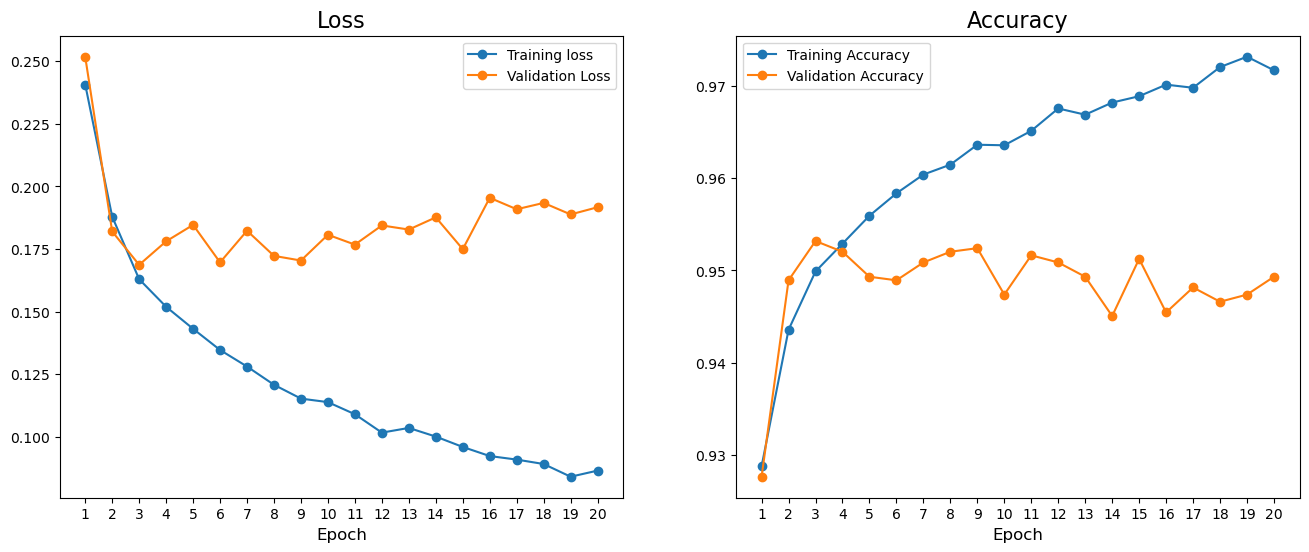

In [19]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,6))
title_fontsize = 16
axis_fontsize = 12

total_epochs = ROUND_2_EPOCHS
# total_epochs += ROUND_2_EPOCHS
# new_rounds = [ROUND_1_EPOCHS + 0.5]

ax1.plot(range(1, total_epochs + 1), history.history['loss'], marker='o', label='Training loss')
ax1.plot(range(1, total_epochs + 1), history.history['val_loss'], marker='o', label='Validation Loss')
ax1.legend()
ax1.set_xticks(range(1, total_epochs + 1))
ax1.set_title('Loss', fontsize=title_fontsize)
ax1.set_xlabel('Epoch', fontsize=axis_fontsize)

ax2.plot(range(1, total_epochs + 1), history.history['accuracy'], marker='o', label='Training Accuracy')
ax2.plot(range(1, total_epochs + 1), history.history['val_accuracy'], marker='o', label='Validation Accuracy')
ax2.legend()
ax2.set_xticks(range(1, total_epochs + 1))
ax2.set_title('Accuracy', fontsize=title_fontsize)
ax2.set_xlabel('Epoch', fontsize=axis_fontsize)

# for new_round in new_rounds:
#     ax1.axvline(new_round, c='tab:green')
#     ax2.axvline(new_round, c='tab:green');

In [20]:
test_loss, test_accuracy = model.evaluate(test)

print('\n\033[1m' + 'The model had an accuracy score of {}%!!'.format(round(100*test_accuracy,1)) + '\033[0m')

21/21 [==============================] - 11s 500ms/step - loss: 0.1112 - accuracy: 0.9694

The model had an accuracy score of 96.9%!!


In [21]:
model_name = 'MobileNetV2'
subject = 'Birds-Species'
acc = test_accuracy * 100
save_path = ''

save_id = str(f'./Models/MobileNetV2/{model_name}-{subject}-FineTune1-{"%.2f" %round(acc, 2)}.h5')
model_save_loc = os.path.join(save_path, save_id)
model.save(model_save_loc)
print(f'model was saved as {model_save_loc}')

model was saved as ./Models/MobileNetV2/MobileNetV2-Birds-Species-FineTune1-96.94.h5


# Fine Tune Again

In [22]:
model.layers[2].trainable = True

print('Setting the last {} layers in the Mobile Net Base Model to trainable!'.format(ROUND_3_TRAINABLE_LAYERS))

for layer in model.layers[2].layers[:-ROUND_3_TRAINABLE_LAYERS]:
    layer.trainable = False

Setting the last 74 layers in the Mobile Net Base Model to trainable!


In [23]:
optimizer_3 = tf.keras.optimizers.Adam(learning_rate = LEARNING_RATE * ROUND_2_LEARNING_SCALER * ROUND_3_LEARNING_SCALER)

callbacks = [model_checkpoint, model.history]

model.compile(optimizer = optimizer_3,
              loss = loss,
              metrics=['accuracy'])

In [24]:
history = model.fit(train, 
                    validation_data=valid, 
                    epochs=ROUND_3_EPOCHS, 
                    callbacks = callbacks)

Epoch 1/20
649/649 [==============================] - ETA: 0s - loss: 0.0742 - accuracy: 0.9765
Epoch 1: val_accuracy improved from 0.95319 to 0.95474, saving model to ./mobilenetv2/Bird-Classifier-Model-Checkpoint.ckpt
649/649 [==============================] - 718s 1s/step - loss: 0.0742 - accuracy: 0.9765 - val_loss: 0.1581 - val_accuracy: 0.9547
Epoch 2/20
649/649 [==============================] - ETA: 0s - loss: 0.0671 - accuracy: 0.9784
Epoch 2: val_accuracy did not improve from 0.95474
649/649 [==============================] - 719s 1s/step - loss: 0.0671 - accuracy: 0.9784 - val_loss: 0.1573 - val_accuracy: 0.9544
Epoch 3/20
649/649 [==============================] - ETA: 0s - loss: 0.0642 - accuracy: 0.9788
Epoch 3: val_accuracy improved from 0.95474 to 0.95590, saving model to ./mobilenetv2/Bird-Classifier-Model-Checkpoint.ckpt
649/649 [==============================] - 720s 1s/step - loss: 0.0642 - accuracy: 0.9788 - val_loss: 0.1561 - val_accuracy: 0.9559
Epoch 4/20
649/64

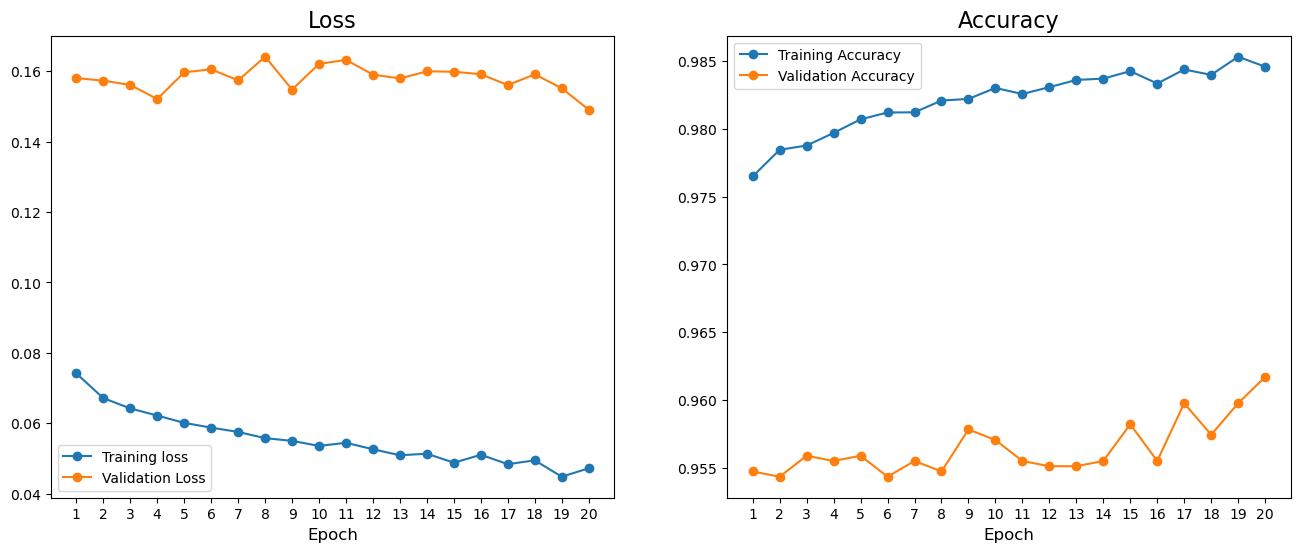

In [25]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,6))
title_fontsize = 16
axis_fontsize = 12

total_epochs = ROUND_3_EPOCHS
# new_rounds += [ROUND_1_EPOCHS + ROUND_2_EPOCHS + 0.5]

ax1.plot(range(1, total_epochs + 1), history.history['loss'], marker='o', label='Training loss')
ax1.plot(range(1, total_epochs + 1), history.history['val_loss'], marker='o', label='Validation Loss')
ax1.legend()
ax1.set_xticks(range(1, total_epochs + 1))
ax1.set_title('Loss', fontsize=title_fontsize)
ax1.set_xlabel('Epoch', fontsize=axis_fontsize)

ax2.plot(range(1, total_epochs + 1), history.history['accuracy'], marker='o', label='Training Accuracy')
ax2.plot(range(1, total_epochs + 1), history.history['val_accuracy'], marker='o', label='Validation Accuracy')
ax2.legend()
ax2.set_xticks(range(1, total_epochs + 1))
ax2.set_title('Accuracy', fontsize=title_fontsize)
ax2.set_xlabel('Epoch', fontsize=axis_fontsize);

# for new_round in new_rounds:
#     ax1.axvline(new_round, c='tab:green')
#     ax2.axvline(new_round, c='tab:green');

# Evaluate Model Accuracy on Test Data

In [26]:
# model.load_weights(MODEL_CHECKPOINT_FILEPATH)

test_loss, test_accuracy = model.evaluate(test)

print('\n\033[1m' + 'The model had an accuracy score of {}%!!'.format(round(100*test_accuracy,1)) + '\033[0m')

21/21 [==============================] - 11s 503ms/step - loss: 0.0926 - accuracy: 0.9768

The model had an accuracy score of 97.7%!!


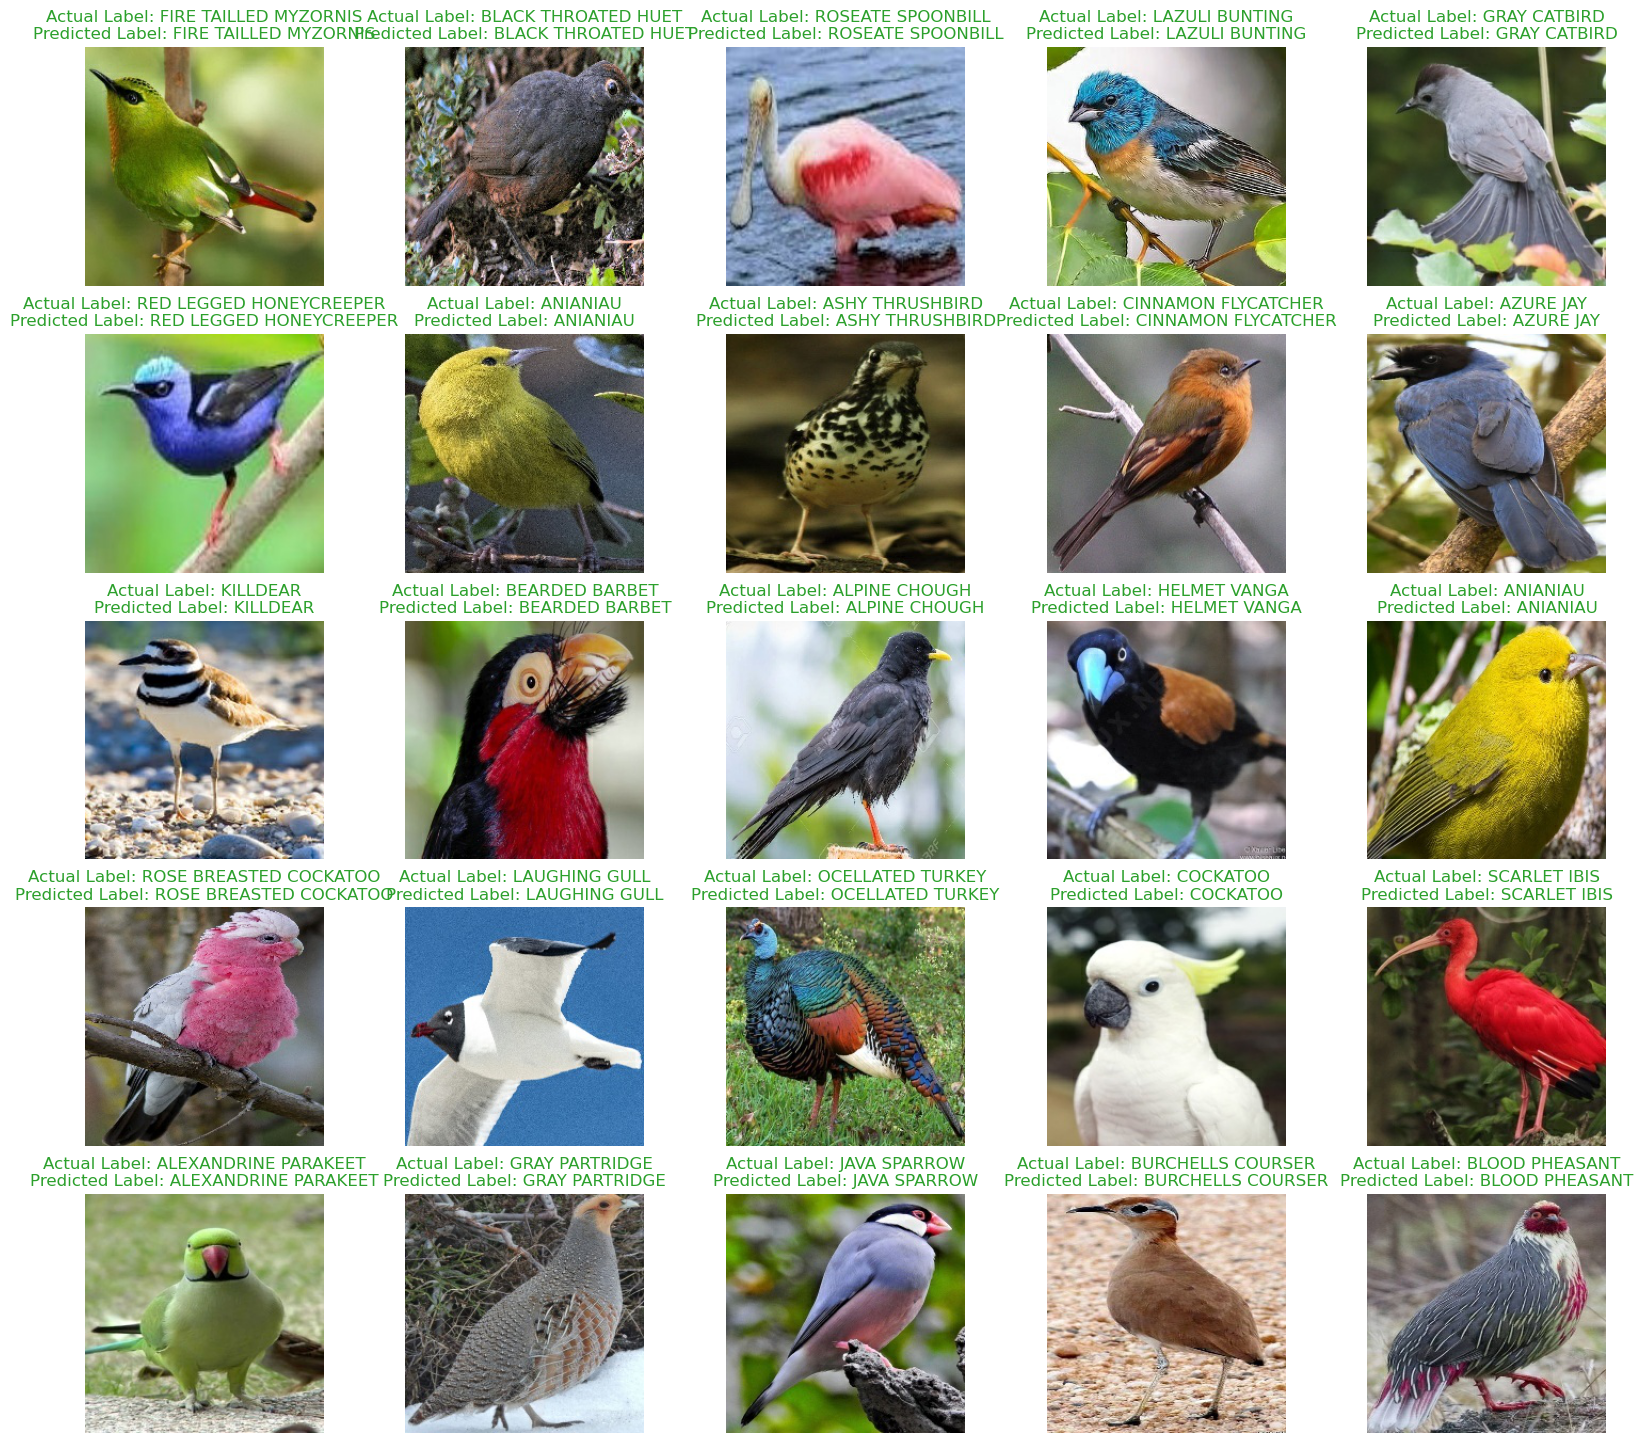

In [27]:
plt.figure(figsize=(20, 18))

for images, labels in test.take(1):
    guesses = np.argmax(model.predict(images), axis=1)
    for i in range(25):
        ax = plt.subplot(5, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        if guesses[i] == np.argmax(labels[i]):
            color = 'tab:green'
        else:
            color = 'tab:red'
        plt.title('Actual Label: {}\nPredicted Label: {}'.format(
                            class_names[np.argmax(labels[i])], class_names[guesses[i]]),
                 color = color)
        plt.axis("off")

In [28]:
model_name = 'MobileNetV2'
subject = 'Birds-Species'
acc = test_accuracy * 100
save_path = ''

save_id = str(f'./Models/MobileNetV2/{model_name}-{subject}-FineTune2-{"%.2f" %round(acc, 2)}.h5')
model_save_loc = os.path.join(save_path, save_id)
model.save(model_save_loc)
print(f'model was saved as {model_save_loc}')

model was saved as ./Models/MobileNetV2/MobileNetV2-Birds-Species-FineTune2-97.68.h5
